In [10]:
# Mount Google Drive
from google.colab import drive
import os

drive.mount('/content/drive')

# Set path to your folder in Google Drive
base_path = '/content/drive/MyDrive/pearl_ml/'

# Libraries for data manipulation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for NLP
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

# Libraries for explainability and uncertainty quantification
from sklearn.inspection import permutation_importance
import shap

video_data = pd.read_csv(os.path.join(base_path, 'GBvideos.csv'), on_bad_lines='skip')
comment_data = pd.read_csv(os.path.join(base_path, 'GBcomments.csv'), on_bad_lines='skip')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Merge datasets on 'video_id'
merged_data = video_data.merge(comment_data, on='video_id', how='left')

# Handle missing values
merged_data.fillna({'comment_text': 'No Comments', 'likes_y': 0, 'replies': 0}, inplace=True)

# Standardize date format
merged_data['date'] = pd.to_datetime(merged_data['date'], errors='coerce')
merged_data.dropna(subset=['date'], inplace=True)

# NLP Sentiment Analysis for Tags and Comments
sia = SentimentIntensityAnalyzer()

# Function to get sentiment scores
def get_sentiment(text):
    sentiment = sia.polarity_scores(str(text))
    if sentiment['compound'] >= 0.05:
        return 1  # Positive
    elif sentiment['compound'] <= -0.05:
        return -1  # Negative
    else:
        return 0   # Neutral

merged_data['tag_sentiment'] = merged_data['tags'].apply(get_sentiment)
merged_data['comment_sentiment'] = merged_data['comment_text'].apply(get_sentiment)

# Encode 'channel_title' and 'title' as genres using Label Encoding
label_encoder = LabelEncoder()
merged_data['channel_title_encoded'] = label_encoder.fit_transform(merged_data['channel_title'])
merged_data['title_encoded'] = label_encoder.fit_transform(merged_data['title'])

# Feature Engineering: Engagement Levels
def engagement_level(row):
    if row['views'] > 1000000:
        return 'high'
    elif row['views'] > 100000:
        return 'medium'
    else:
        return 'low'

merged_data['engagement'] = merged_data.apply(engagement_level, axis=1)

# Encode engagement levels
merged_data['engagement_encoded'] = label_encoder.fit_transform(merged_data['engagement'])

# Select relevant features and target
features = ['tag_sentiment', 'comment_sentiment', 'channel_title_encoded', 'title_encoded', 'likes_x', 'dislikes', 'replies']
target = 'engagement_encoded'

X = merged_data[features]
y = merged_data[target]

# Normalize numerical features
scaler = MinMaxScaler()
X[['likes_x', 'dislikes', 'replies']] = scaler.fit_transform(X[['likes_x', 'dislikes', 'replies']])

<ipython-input-3-a84f607071f0>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['likes_x', 'dislikes', 'replies']] = scaler.fit_transform(X[['likes_x', 'dislikes', 'replies']])


In [6]:
# Import necessary libraries
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Assuming features and target are already defined:
# X = DataFrame with features
# y = Target variable: 'engagement_encoded'

# Step 1: Split full data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 2: Reduce dataset size for faster testing
X_train_sample, X_unused, y_train_sample, y_unused = train_test_split(
    X_train, y_train, test_size=0.9, random_state=42, stratify=y_train
)

# Step 3: Initialize Random Forest with optimized parameters
rf = RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=-1)  # Use parallel processing

# Step 4: Cross-validation setup
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf, X_train_sample, y_train_sample, cv=cv, scoring='accuracy', n_jobs=-1)

# Step 5: Cross-validation results
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", np.mean(cv_scores))

# Step 6: Train the model on the reduced dataset
rf.fit(X_train_sample, y_train_sample)

# Step 7: Evaluate the model on the full test set
y_pred = rf.predict(X_test)

# Step 8: Model performance
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Cross-validation scores: [0.99992576 0.99976243 0.99980697 0.99979212 0.9995397 ]
Mean CV accuracy: 0.9997653985621211
Test Accuracy: 0.9999239775876425
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    256642
           1       1.00      1.00      1.00    127967
           2       1.00      1.00      1.00    457248

    accuracy                           1.00    841857
   macro avg       1.00      1.00      1.00    841857
weighted avg       1.00      1.00      1.00    841857



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without

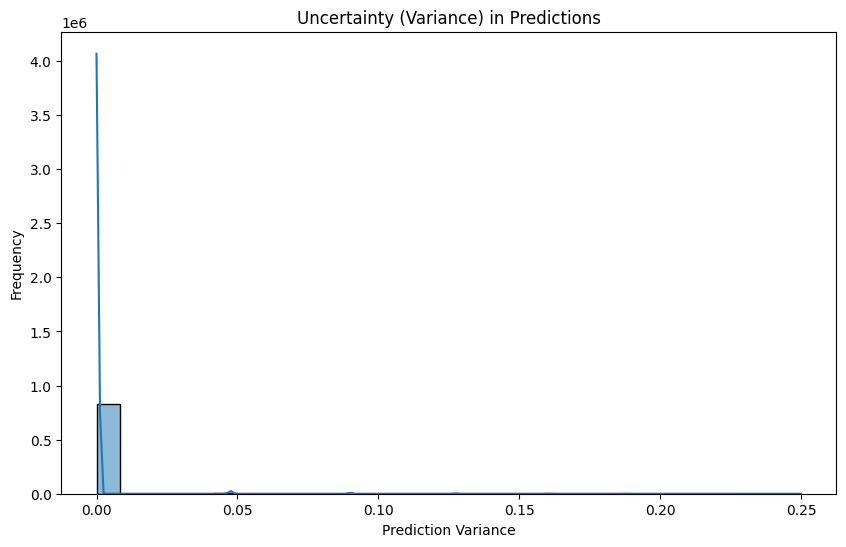

         Mean Prediction  Variance  True Label
2395382              0.0       0.0           0
3373329              0.0       0.0           2
3327715              1.0       0.0           1
635211               0.0       0.0           0
91940                0.0       0.0           0


In [8]:
import numpy as np

# Get predictions from each estimator in Random Forest
ensemble_preds = np.array([tree.predict_proba(X_test)[:, 1] for tree in rf.estimators_])

# Compute mean and variance across predictions
mean_preds = np.mean(ensemble_preds, axis=0)
variance_preds = np.var(ensemble_preds, axis=0)

# Visualize uncertainty (variance distribution)
plt.figure(figsize=(10, 6))
sns.histplot(variance_preds, bins=30, kde=True)
plt.title("Uncertainty (Variance) in Predictions")
plt.xlabel("Prediction Variance")
plt.ylabel("Frequency")
plt.show()

# Output predictions and variance for a few samples
uncertainty_df = pd.DataFrame({
    'Mean Prediction': mean_preds,
    'Variance': variance_preds,
    'True Label': y_test
})
print(uncertainty_df.head())

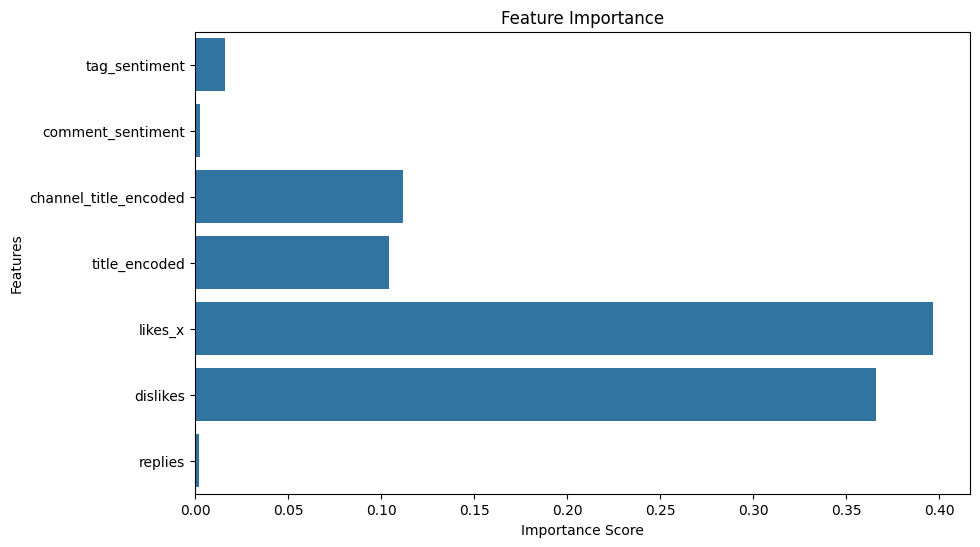

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature importance from Random Forest
feature_importances = rf.feature_importances_

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=X_train.columns)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()